# 1. Base Model 생성

## (1) 데이터 준비

In [1]:
# My Google Drive Mount하기!
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255.0)
val_datagen = ImageDataGenerator(rescale=1/255.0)

train_dir = '/content/drive/MyDrive/03. Kookmin AI Big Data MBA/Semester 3_032021-062021/2. Deep Learning/Jupyter Notebook/data_Week 09/train'
val_dir = '/content/drive/MyDrive/03. Kookmin AI Big Data MBA/Semester 3_032021-062021/2. Deep Learning/Jupyter Notebook/data_Week 09/validation'

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

# 만약에 Multi-class Classification일 경우:
    # class_mode='categorical' OR 'sparse'로 적어주면 된다!

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [3]:
for train_input_batch, train_target_batch in train_gen:
    print('Size of Batch (Train Input):', train_input_batch.shape)
    print('Size of Batch (Train Target):', train_target_batch.shape)
    break

Size of Batch (Train Input): (20, 150, 150, 3)
Size of Batch (Train Target): (20,)


## (2) 모델 정의

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

## (3) 모델 시각화

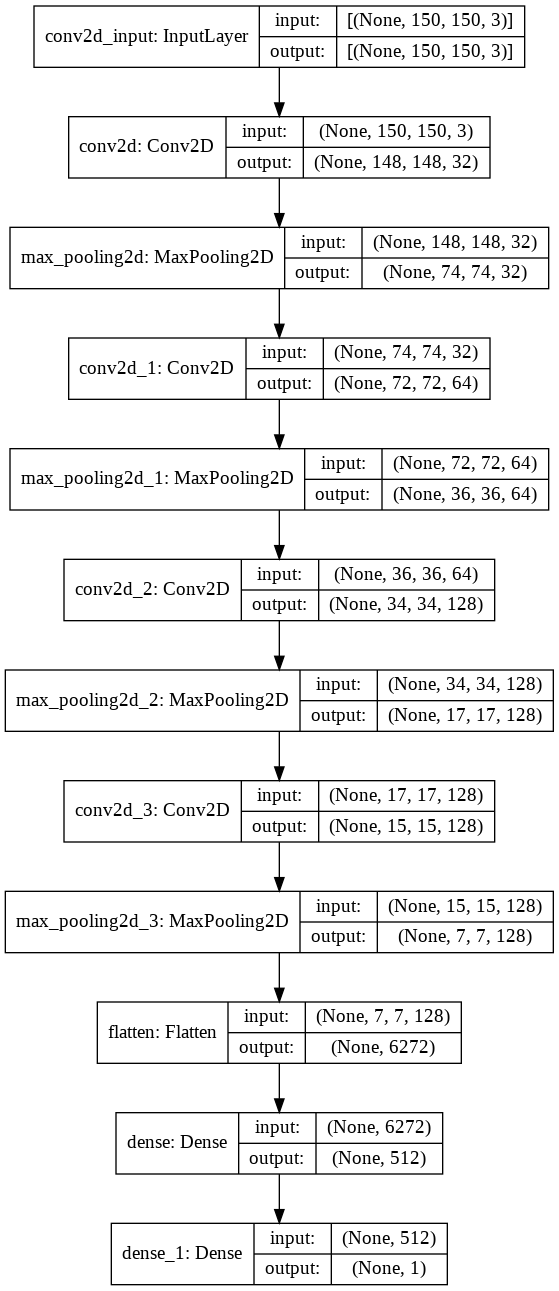

In [5]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True)

## (4) 컴파일

In [6]:
from tensorflow.keras.optimizers import RMSprop

model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=0.0001),
    metrics=['accuracy']
)

# Tabular 혹은 Textual Data에 비해, Image Data의 경우, learning rate을 훨씬 작게 해야 결과가 잘 나옴!

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


## (5) 모델 학습

In [10]:
history = model.fit(
    train_gen,
    steps_per_epoch=100,
    epochs=2,
    validation_data=val_gen,
    validation_steps=50
)

# steps_per_epoch: 1 epoch 마다 몇 개의 batch를 뽑아낼 것인지를 결정함!
    # 위에서 train_generator의 batch_size=20으로 설정했으므로,
    # steps_per_epoch을 100으로 설정하면,
    # 총 2,000개의 데이터를 모두 1 epoch마다 모두 학습할 수 있겠군!

Epoch 1/2
100/100 [==============================] - 1878s 19s/step - loss: 0.6865 - accuracy: 0.5395 - val_loss: 0.6742 - val_accuracy: 0.5510
Epoch 2/2
100/100 [==============================] - 16s 156ms/step - loss: 0.6574 - accuracy: 0.6060 - val_loss: 0.6541 - val_accuracy: 0.5970


## (6) 모델 저장

In [11]:
model.save('/content/drive/MyDrive/03. Kookmin AI Big Data MBA/Semester 3_032021-062021/2. Deep Learning/Jupyter Notebook/data_Week 09/cats_and_dogs_small_1.h5')

## (7) 성능평가 시각화

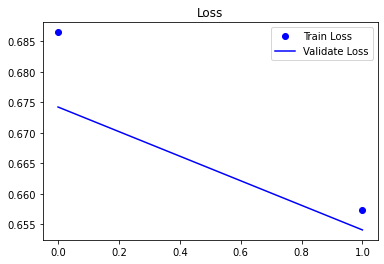

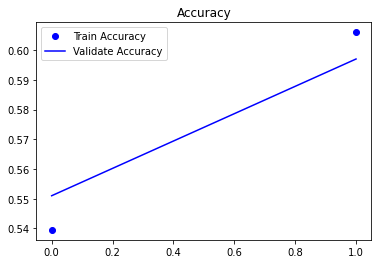

''

In [12]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epoch_list = range(len(train_acc))

plt.plot(epoch_list, train_loss, 'bo', label='Train Loss')
plt.plot(epoch_list, val_loss, 'b', label='Validate Loss')
plt.title('Loss')
plt.legend()

plt.figure()

plt.plot(epoch_list, train_acc, 'bo', label='Train Accuracy')
plt.plot(epoch_list, val_acc, 'b', label='Validate Accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()
;

* Weight는 총 3M 개가 넘는데, 데이터가 2,000개 밖에 안되기 때문에, 제대로 학습이 안되는군...!
    * Memory Effect & Overfitting!

# 2. Overfitting을 줄여보자! (with 데이터 증식)

## (1) 데이터 준비

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

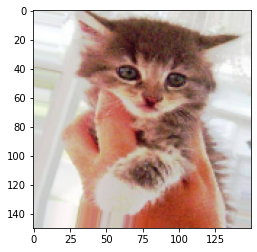

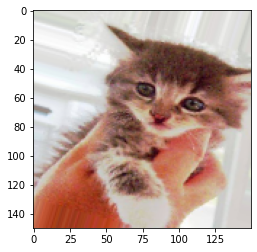

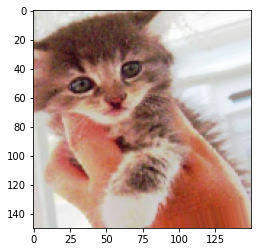

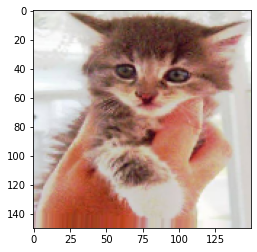

''

In [16]:
from tensorflow.keras.preprocessing import image
import os
import matplotlib.pyplot as plt
%matplotlib inline

train_cats_dir = '/content/drive/MyDrive/03. Kookmin AI Big Data MBA/Semester 3_032021-062021/2. Deep Learning/Jupyter Notebook/data_Week 09/train/cats'

fname_list = sorted([os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)])
fpath = fname_list[3]

img = image.load_img(fpath, target_size=(150, 150))
img_arr = image.img_to_array(img)
img_arr = img_arr.reshape((1, ) + img_arr.shape)

iBatch = 0
for batch in datagen.flow(img_arr, batch_size=1):
    plt.figure(iBatch)
    img_plot = plt.imshow(image.array_to_img(batch[0]))
    iBatch = iBatch + 1
    if iBatch % 4 == 0:
        break

plt.show()
;

In [17]:
train_dir = '/content/drive/MyDrive/03. Kookmin AI Big Data MBA/Semester 3_032021-062021/2. Deep Learning/Jupyter Notebook/data_Week 09/train'
val_dir = '/content/drive/MyDrive/03. Kookmin AI Big Data MBA/Semester 3_032021-062021/2. Deep Learning/Jupyter Notebook/data_Week 09/validation'

train_datagen = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=50,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    rescale=1/255.0
)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

* CNN에서는, Filtering과 Pooling에서는 Dropout을 사용하지 않고, 보통 Flatten을 한 다음에 Dropout을 준다!

## (2) 모델 시각화

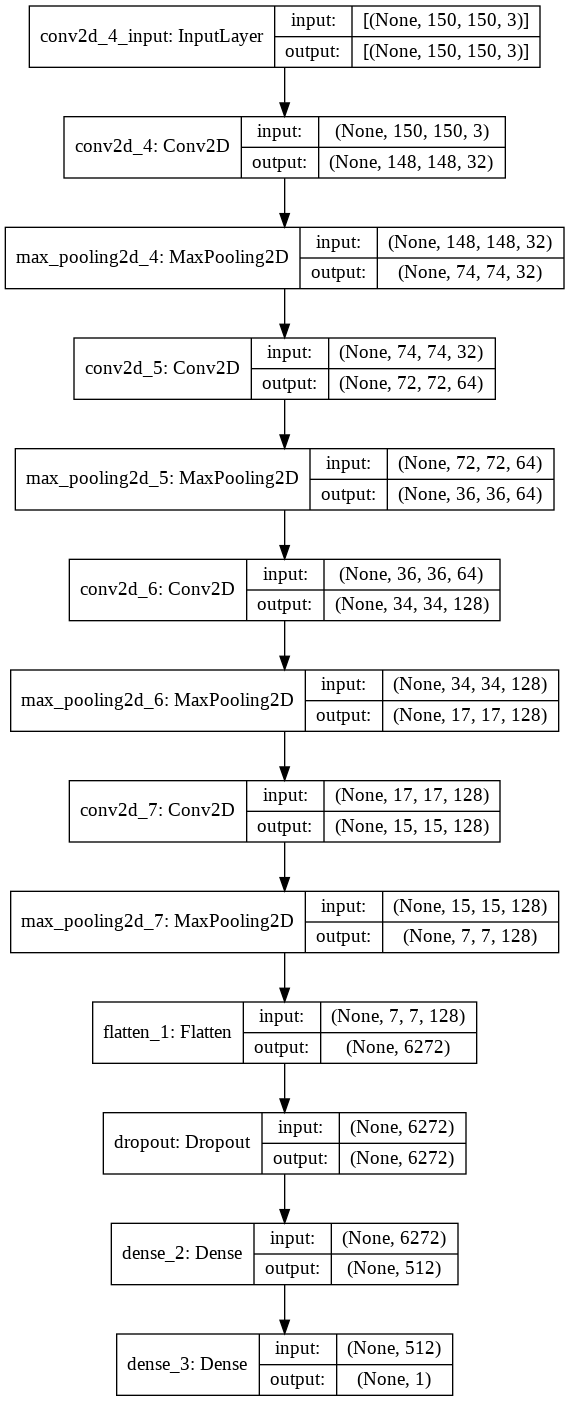

In [19]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True)

## (3) 컴파일

In [20]:
from tensorflow.keras.optimizers import RMSprop

model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=0.0001),
    metrics=['accuracy']
)

# Tabular 혹은 Textual Data에 비해, Image Data의 경우, learning rate을 훨씬 작게 해야 결과가 잘 나옴!

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


## (4) 모델 학습

In [21]:
history = model.fit(
    train_gen,
    steps_per_epoch=100,
    epochs=5,
    validation_data=val_gen,
    validation_steps=50
)

# 강의에서는 epochs=100으로 주었는데, 시간 관계상 5만 주도록 한다.

# steps_per_epoch: 1 epoch 마다 몇 개의 batch를 뽑아낼 것인지를 결정함!
    # 위에서 train_generator의 batch_size=20으로 설정했으므로,
    # steps_per_epoch을 100으로 설정하면,
    # 총 2,000개의 데이터를 모두 1 epoch마다 모두 학습할 수 있겠군!

Epoch 1/5
100/100 [==============================] - 27s 258ms/step - loss: 0.6961 - accuracy: 0.4985 - val_loss: 0.6919 - val_accuracy: 0.5060
Epoch 2/5
100/100 [==============================] - 25s 255ms/step - loss: 0.6898 - accuracy: 0.5250 - val_loss: 0.6701 - val_accuracy: 0.5970
Epoch 3/5
100/100 [==============================] - 26s 258ms/step - loss: 0.6780 - accuracy: 0.5750 - val_loss: 0.6569 - val_accuracy: 0.6110
Epoch 4/5
100/100 [==============================] - 26s 258ms/step - loss: 0.6721 - accuracy: 0.5795 - val_loss: 0.6496 - val_accuracy: 0.5950
Epoch 5/5
100/100 [==============================] - 26s 259ms/step - loss: 0.6596 - accuracy: 0.5850 - val_loss: 0.6578 - val_accuracy: 0.5690


* epoch을 늘려야, image를 뽑을 때마다, 데이터 증식을 진행하게 된다! (그래서 epoch을 늘린 것임!)

## (5) 모델 저장

In [22]:
model.save('/content/drive/MyDrive/03. Kookmin AI Big Data MBA/Semester 3_032021-062021/2. Deep Learning/Jupyter Notebook/data_Week 09/cats_and_dogs_small_2.h5')

## (6) 성능평가 시각화

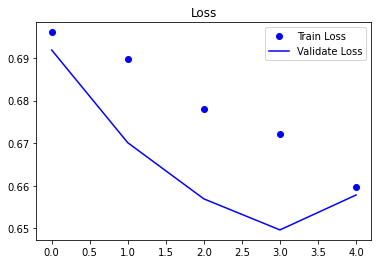

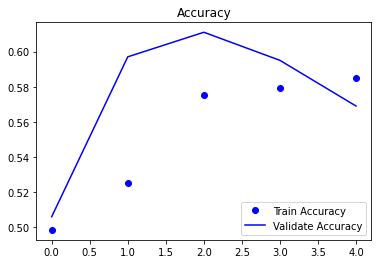

''

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

train_loss = history.history['loss']
val_loss = history.history['val_loss']

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epoch_list = range(len(train_loss))

plt.plot(epoch_list, train_loss, 'bo', label='Train Loss')
plt.plot(epoch_list, val_loss, 'b', label='Validate Loss')
plt.title('Loss')
plt.legend()

plt.figure()

plt.plot(epoch_list, train_acc, 'bo', label='Train Accuracy')
plt.plot(epoch_list, val_acc, 'b', label='Validate Accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()
;